# Compute $R^\prime_{HK}$ for HAT-P-11 and other stars
##### Brett Morris

Using relations from [Mittag et al 2013](http://adsabs.harvard.edu/abs/2013A%26A...549A.117M)

*** 

First load in HAT-P-11 $S$-index measurements from APO

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from astropy.time import Time
from astropy.io import ascii

from toolkit import (json_to_stars, Measurement, stars_to_json, FitParameter,
                     parse_hires, StarProps)

props = dict(fontsize=15)

hat11 = json_to_stars('data/hat11.json')

f = FitParameter.from_text('calibration_constants/calibrated_f.txt')
c1 = FitParameter.from_text('calibration_constants/calibrated_c1.txt')
c2 = FitParameter.from_text('calibration_constants/calibrated_c2.txt')

hat11_s_apo = Measurement([s.s_apo.uncalibrated.value for s in hat11],
                          err=[s.s_apo.uncalibrated.err for s in hat11],
                          time=[s.s_apo.time.jd for s in hat11])

##############################################################################
# Solve for HAT-P-11 S-indices:
hat11_s_mwo_err = np.sqrt((f.value * hat11_s_apo.value * c1.err_lower)**2 +
                          (c1.value * f.value * hat11_s_apo.err)**2 +
                          c2.err_lower**2)

hat11_s_mwo = Measurement(c1.value * hat11_s_apo.value + c2.value,
                          err=hat11_s_mwo_err,
                          time=hat11_s_apo.time)

hat11_apo_calibrated = [StarProps(name='HAT-P-11', s_apo=sapo, s_mwo=smwo,
                                  time=sapo.time)
                        for sapo, smwo in zip(hat11_s_apo, hat11_s_mwo)]

stars_to_json(hat11_apo_calibrated, 'data/hat11_apo_calibrated.json')

#############################################################################
# Plot the S-index time series for HAT-P-11 with HIRES data too
hires = parse_hires('hat-p-11_svals.txt')

last_week_inds = np.argsort(hat11_s_apo.time.jd)[-8:]
hat11_s_mwo_mean = c1.value * hat11_s_apo.value[last_week_inds].mean() + c2.value
hat11_s_apo_err_mean = np.sqrt(np.sum(hat11_s_apo.err[last_week_inds]**2 /
                                      len(last_week_inds)**2))
hat11_s_mwo_mean_err = np.sqrt((hat11_s_apo.value[last_week_inds].mean() * c1.err_lower)**2 +
                               (c1.value * hat11_s_apo_err_mean)**2 +
                               c2.err_lower**2)


rm = (hires['time'].decimalyear < 2010.7) & (hires['time'].decimalyear > 2010.6)
rough_hires_err = np.std(hires[rm]['S-value'])

hat11_s_keck = Measurement(value=hires['S-value'].data,
                           err=rough_hires_err * np.ones(len(hires['S-value'].data)),
                           time=hires['time'])

hat11_keck_calibrated = [StarProps(name='HAT-P-11', s_mwo=s, time=s.time)
                         for s in hat11_s_keck]

times = np.hstack([hires['time'].decimalyear, hat11_s_apo.time.decimalyear])
sind = np.hstack([hires['S-value'], hat11_s_mwo.value])
sind_err = np.hstack([rough_hires_err * np.ones(len(hires['S-value'].data)), hat11_s_mwo.err])

Define a bunch of equations from Mittag+ 2013

In [3]:
s_mean_h11 = np.mean(sind)

sigma_sb = 5.67051e-5 # http://www.astro.wisc.edu/~dolan/constants.html
import astropy.units as u

def c_cf(b_minus_v):
    # Mittag 2013, eq. 7 (main sequence):
    return 10**(0.25*b_minus_v**3 - 1.33*b_minus_v**2 + 0.43*b_minus_v + 0.24)

alpha_apo = np.loadtxt('calibration_constants/calibrated_c1.txt')[0]
alpha_mwo = 19.2
alpha_keck = 32.510

def scriptf_hk(s, b_minus_v, t_eff, alpha_ratio=1): #alpha_mwo/alpha_apo):
    # Mittag 2013
    K = 10**(6.086 - 0.2088*b_minus_v + 0.3564*b_minus_v**2 - 0.002*b_minus_v**3) / alpha_ratio # Eqn. 12
    F_hk = c_cf(b_minus_v) * t_eff**4 * 1e-14 * s # eqn 9
    return K * F_hk # eqn 10

def scriptf_hkphot(b_minus_v):
    # Mittag 2013 eqn 20:
    return 10**(7.49 - 2.06 * b_minus_v)

def rprime_hk(s, b_minus_v, t_eff, alpha_ratio=1):
    # Mittag 2013 eqn 24
    return (scriptf_hk(s, b_minus_v, t_eff, alpha_ratio=alpha_ratio) - scriptf_hkphot(b_minus_v)) / (sigma_sb * t_eff**4)

def log_rprime_hk(s, b_minus_v, t_eff, alpha_ratio=1):
    return np.log10(rprime_hk(s, b_minus_v, t_eff, alpha_ratio=alpha_ratio))

def bv_2_teff(b_minus_v):
    # Mittag eqn. 3
    return 10**(3.981 - 0.4728*b_minus_v + 0.2434*b_minus_v**2 - 0.0620*b_minus_v**3) 

Download the $S$-index catalog from [Duncan+ 1991](http://adsabs.harvard.edu/abs/1991ApJS...76..383D), compute $R^\prime_{HK}$ for those stars

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


[<matplotlib.text.Text at 0x1185813c8>, <matplotlib.text.Text at 0x11814ba20>]

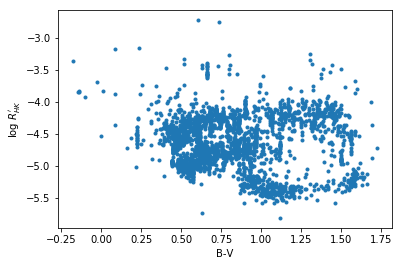

In [4]:
from toolkit import get_duncan_catalog

table = get_duncan_catalog()

b_minus_v = (table['Bmag'] - table['Vmag']).data
t_eff = bv_2_teff(b_minus_v)
s = table['Smean'].data

logrprime = log_rprime_hk(s, b_minus_v, t_eff)

fig, ax = plt.subplots()
ax.plot(b_minus_v, logrprime, '.')
ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')

In [5]:
log_rprime_hk(s_mean_h11, 1.19, 4750)

-4.4016146929951443

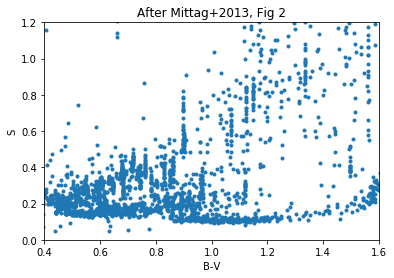

In [6]:
plt.plot(b_minus_v, table['Smean'], '.')
plt.ylim([0, 1.2])
plt.xlim([0.4, 1.6])
plt.title('After Mittag+2013, Fig 2')
plt.xlabel('B-V')
plt.ylabel('S')

Must cross-match targets against Hipparcos table: `I/239/hip_main`

In [7]:
with open('data/duncan_targets.txt', 'w') as w:
    w.write('\n'.join(map(lambda x: "{0:s}".format(x), np.unique(table['SName'].data.data))))

We're looking for just the main sequence stars in the Duncan and Wright catalogs, so we'll put all stars on a calibrated HR diagram with Hipparcos parallaxes

Absolute magnitude $M_V$ from apparent mag $m_V$:
$$M_V=m_V-5\left(\log _{10}d-1\right)$$

where $d$ is distance in parsec which can be computed from parallax with: 

$$d = \frac{1}{\textrm{parallax half-angle in arcsec}}$$

In [8]:
from astropy.table import Column
hipp1 = ascii.read('data/duncan_hipparcos_crossmatch.tsv', header_start=0, data_start=56, delimiter='\t')

hipp2 = ascii.read('data/wright_hipparcos_crossmatch.tsv', header_start=0, data_start=56, delimiter='\t')
hipp2['_1'] = Column([line.strip() for line in hipp2['_1'].data.data], "_1")
hipp2.add_index('_1')
hipp2['B-V'] = Column(np.array(list(map(lambda x: float(x) if len(x.strip()) > 1 else 0, hipp2['B-V'].data))), 'B-V')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


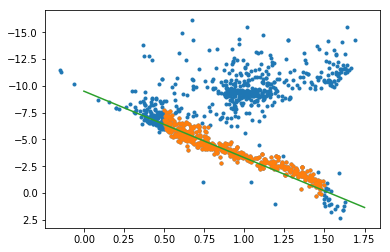

In [9]:
hipp1['_1'] = Column([line.strip() for line in hipp1['_1'].data.data], "_1")
hipp1.add_index('_1')

parallax_arcsec = (hipp1['Plx']/1000)
dist_pc = 1./parallax_arcsec
M_V = hipp1['Vmag'] - 5*(np.log10(dist_pc) + 1)

x = np.linspace(0, 1.75)
def color_cut(b_minus_v):
    return -9.5 + 6.2*b_minus_v

main_sequence = (np.abs(M_V - color_cut(hipp1['B-V'])) < 1.5) & (hipp1['B-V'] > 0.5) & (hipp1['B-V'] < 1.5)

y = color_cut(x)
from astropy.table import Column
hipp1.add_column(Column(main_sequence, 'MS'))

fig, ax = plt.subplots()
ax.plot(hipp1['B-V'], M_V, '.')
ax.plot(hipp1['B-V'][main_sequence], M_V[main_sequence], '.')
ax.plot(x, y)
ax.invert_yaxis();

In [10]:
main_sequence_ids = []
mwo_target_names = list(map(lambda x: "{0:s}".format(x), table['SName'].data.data))
for mwo_target in mwo_target_names:
    if mwo_target in hipp1['_1'].data.data:
        if not hasattr(hipp1.loc[mwo_target]['MS'], '__len__'):
            main_sequence_ids.append(hipp1.loc[mwo_target]['MS'])
        else: 
            main_sequence_ids.append(hipp1.loc[mwo_target]['MS'][0])
    else: 
        main_sequence_ids.append(False)

if 'MS' not in table.colnames:
    table.add_column(Column(main_sequence_ids, 'MS'))
else: 
    table['MS'] = Column(main_sequence_ids, 'MS')

In [11]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = 1e10   # Otherwise would only show first 50 values
wright = Vizier.get_catalogs('J/ApJS/152/261/table1')[0]

with open('data/wright_targets.txt', 'w') as w:
    w.write('\n'.join(map(lambda x: "{0:s}".format(x), np.unique(wright['SimbadName'].data.data))))

[<matplotlib.text.Text at 0x118be3908>, <matplotlib.text.Text at 0x118bdb390>]

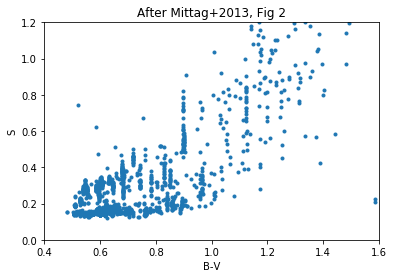

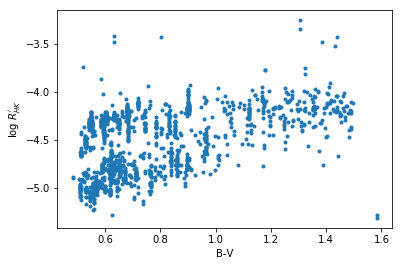

In [12]:
b_minus_v_ms = (table['Bmag'] - table['Vmag']).data[table['MS']]
t_eff_ms = 10**(3.981 - 0.4728*b_minus_v_ms + 0.2434*b_minus_v_ms**2 - 0.0620*b_minus_v_ms**3) # Mittag eqn. 3
s_ms = table['Smean'].data[table['MS']]

plt.plot(b_minus_v_ms, s_ms, '.')
plt.ylim([0, 1.2])
plt.xlim([0.4, 1.6])
plt.title('After Mittag+2013, Fig 2')
plt.xlabel('B-V')
plt.ylabel('S')

logrprime_ms = log_rprime_hk(s_ms, b_minus_v_ms, t_eff_ms)

fig, ax = plt.subplots()
ax.plot(b_minus_v_ms, logrprime_ms, '.')
ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')

In [13]:
wright_grouped = wright.group_by('SimbadName').groups.aggregate(np.mean)
wright_grouped.add_index('SimbadName')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


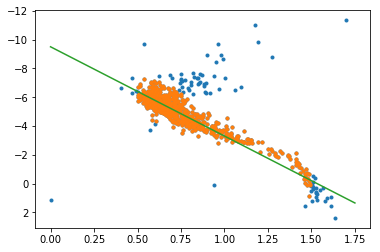

In [14]:
parallax_arcsec = (hipp2['Plx']/1000)
dist_pc = 1./parallax_arcsec
M_V = hipp2['Vmag'] - 5*(np.log10(dist_pc) + 1)

x = np.linspace(0, 1.75)
def color_cut(b_minus_v):
    return -9.5 + 6.2*b_minus_v

main_sequence = (np.abs(M_V - color_cut(hipp2['B-V'])) < 1.5) & (hipp2['B-V'] > 0.5) & (hipp2['B-V'] < 1.5)

y = color_cut(x)
hipp2.add_column(Column(main_sequence, 'MS'))

fig, ax = plt.subplots()
ax.plot(hipp2['B-V'], M_V, '.')
ax.plot(hipp2['B-V'][main_sequence], M_V[main_sequence], '.')
ax.plot(x, y)
ax.invert_yaxis();

In [15]:
from astropy.table import vstack
hipp = vstack([hipp1, hipp2])

In [16]:
hipp.add_index('_1')

[<matplotlib.text.Text at 0x1193fb2b0>, <matplotlib.text.Text at 0x1193daba8>]

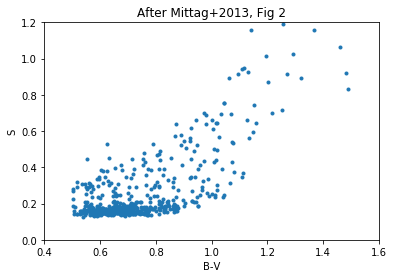

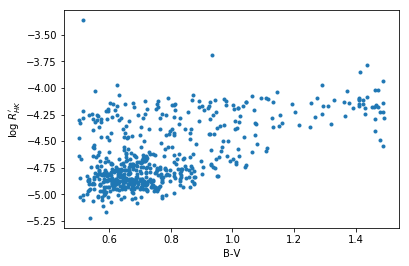

In [17]:
main_sequence_ids = []
b_minus_v_wright = []
mwo_target_names = list(map(lambda x: "{0:s}".format(x), wright_grouped['SimbadName'].data.data))
for mwo_target in mwo_target_names:

    if mwo_target in hipp['_1'].data.data:
        if not hasattr(hipp.loc[mwo_target]['MS'], '__len__'):
            main_sequence_ids.append(hipp.loc[mwo_target]['MS'])
            b_minus_v_wright.append(hipp.loc[mwo_target]['B-V'])
        else: 
            main_sequence_ids.append(hipp.loc[mwo_target]['MS'][0])
            b_minus_v_wright.append(0)
    else: 
        main_sequence_ids.append(False)
        b_minus_v_wright.append(0)

if 'MS' not in wright_grouped.colnames:
    wright_grouped.add_column(Column(main_sequence_ids, 'MS'))
else: 
    wright_grouped['MS'] = Column(main_sequence_ids, 'MS')

if 'B-V' not in wright_grouped.colnames:
    wright_grouped.add_column(Column(b_minus_v_wright, 'B-V'))
else: 
    wright_grouped['B-V'] = b_minus_v_wright

b_minus_v_ms_w = wright_grouped['B-V'].data[wright_grouped['MS']]
t_eff_ms_w = 10**(3.981 - 0.4728*b_minus_v_ms_w + 0.2434*b_minus_v_ms_w**2 - 0.0620*b_minus_v_ms_w**3) # Mittag eqn. 3
s_ms_w = wright_grouped['Sdiff'].data[wright_grouped['MS']]

plt.plot(b_minus_v_ms_w, s_ms_w, '.')
plt.ylim([0, 1.2])
plt.xlim([0.4, 1.6])
plt.title('After Mittag+2013, Fig 2')
plt.xlabel('B-V')
plt.ylabel('S')

logrprime_ms_w = log_rprime_hk(s_ms_w, b_minus_v_ms_w, t_eff_ms_w, alpha_ratio=1)

fig, ax = plt.subplots()
ax.plot(b_minus_v_ms_w, logrprime_ms_w, '.')
ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')

Also incorporate values from Isaacson 2010: 

In [18]:
isaacson = Vizier.get_catalogs('J/ApJ/725/875/table1')[0]

b_minus_v_ms_i = isaacson['B-V'].data.data
teff_i = bv_2_teff(b_minus_v_ms_i)
sind_i = isaacson['SHK'].data.data
logrprime_ms_i_computed = log_rprime_hk(sind_i, b_minus_v_ms_i, teff_i, alpha_ratio=alpha_keck/alpha_apo)
logrprime_ms_i = isaacson['logRHK']

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


In [20]:
N_stars_total = np.sum([np.count_nonzero(np.isfinite(l)) 
                        for l in [logrprime_ms_w, logrprime_ms, logrprime_ms_i]])
print("Number of MS comparison stars considered:", N_stars_total)

Number of MS comparison stars considered: 3693


logrprime_h11 -4.35399428022
logrprime_sun -4.72141436147


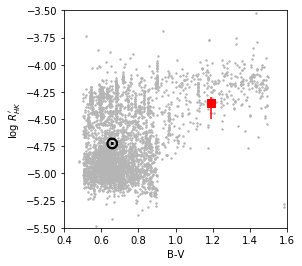

In [24]:
gray_color = '#b5b5b5'
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(b_minus_v_ms_w, logrprime_ms_w, marker='.', color=gray_color, s=8)
ax.scatter(b_minus_v_ms, logrprime_ms, marker='.', color=gray_color, s=8)
ax.scatter(b_minus_v_ms_i, logrprime_ms_i, marker='.', color=gray_color, s=8, zorder=-10)

h11_extremes = [func(np.concatenate([hires['S-value'].data.data, hat11_s_mwo.value])) for func in [np.min, np.max]]

logrprime_h11_mean = log_rprime_hk(s_mean_h11, 1.19, 4750, alpha_ratio=alpha_mwo/alpha_apo)
logrprime_h11_min = log_rprime_hk(h11_extremes[0], 1.19, 4750, alpha_ratio=alpha_mwo/alpha_apo)
logrprime_h11_max = log_rprime_hk(h11_extremes[1], 1.19, 4750, alpha_ratio=alpha_mwo/alpha_apo)

# ax.scatter(1.19, logrprime_h11_mean, marker='s', color='r', s=100)
yerr = np.array([np.abs(logrprime_h11_mean - 
                        np.array([logrprime_h11_min, logrprime_h11_max]))]).T
ax.errorbar(1.19, logrprime_h11_mean, fmt='s', markersize=8, color='r', 
            yerr=yerr)

#ax.scatter(1.19, logrprime_h11_min, marker='s', color='k', s=50)
#ax.scatter(1.19, logrprime_h11_max, marker='s', color='k', s=50)

b_minus_v_sun = 0.653
sind_sun = 0.175
teff_sun = 5777

logrprime_sun = log_rprime_hk(sind_sun, b_minus_v_sun, teff_sun)

ax.scatter(b_minus_v_sun, logrprime_sun, marker='$\odot$', color='k', s=150)

ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$', 
       xlim=[0.4, 1.6], ylim=[-5.5, -3.5])

plt.savefig('plots/rprime.png', bbox_inches='tight', dpi=200)
plt.savefig('plots/rprime.pdf', bbox_inches='tight', dpi=200)

print('logrprime_h11', logrprime_h11_mean)
print('logrprime_sun', logrprime_sun)